In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [2]:
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [5]:
from sklearn.metrics import mean_squared_error as mse

In [6]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader

In [7]:
df = pd.read_csv('inputs/SVMD_1.csv')

In [8]:
df

,IMF-1,IMF-2,IMF-3,IMF-4
0,7.850187,-0.843075,-0.029416,0.683727
1,7.850133,-0.838198,-0.025512,0.638413
2,7.850024,-0.828471,-0.017903,0.550865
3,7.849860,-0.813951,-0.006975,0.427030
4,7.849637,-0.794723,0.006710,0.275308
...,...,...,...,...
1435,8.992862,-0.264966,0.921262,-0.225028
1436,8.991859,-0.270280,1.033266,-0.342685
1437,8.991105,-0.274290,1.119610,-0.438165
1438,8.990603,-0.276974,1.178303,-0.505399


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
imfs = np.array([df[col].values for col in df.columns])

In [10]:
imfs[0].shape

(1440,)

In [11]:
from processing import create_features, split_data

In [13]:
from LSSVMRegression import LSSVMRegression as LSSVM

ImportError: cannot import name 'LSSVMRegression' from 'LSSVMRegression' (c:\Users\ELITE\Documents\windspeed_prediction\LSSVMRegression.py)

In [62]:
from ebqpso import EBQPSO

In [64]:
def adjust_params(params):
    gamma = np.power(10, params[0]).astype(float)
    sigma = np.power(10, params[1]).astype(float)
    m = int(params[2])
    return [gamma, sigma, m]

In [65]:
def get_test_error():
    series = pd.Series(imf1)
    df = create_features(series, param_imf1['m'])
    tr_arr, val_arr, tes_arr = split_data(df, int(.6*df.shape[0]))
    ytr = tr_arr['t']
    xtr = tr_arr.drop('t', axis=1)
    yte = tes_arr['t']
    xte = tes_arr.drop('t', axis=1)

    reg = LSSVM(kernel='rbf', gamma=param_imf1['gamma'], sigma=param_imf1['sigma'])
    reg.fit(xtr, ytr)
    yp = reg.predict(xte)
    mse(yte, yp)

In [66]:
global X

In [75]:
def f(p):
    gamma = np.power(10, p[0]).astype(float)
    sigma = np.power(10, p[1]).astype(float)
    m = int(p[2])
#     series = pd.Series(X)
    x, y = create_features(X, m)
    tr_len = int(.5*X.shape[0])
    Xtr, Xval, Xte = split_data(x, tr_len)
    ytr, yval, yte = split_data(y, tr_len)
#     ytr = tr_arr['t']
#     xtr = tr_arr.drop('t', axis=1)
#     yval = val_arr['t']
#     xval = val_arr.drop('t', axis=1)
    
    reg = LSSVM(kernel='rbf', gamma=gamma, sigma=sigma)
    reg.fit(Xtr, ytr)
    yp = reg.predict(Xval)
    return mse(yval, yp)

In [76]:
D = 3
lb = [-2, -2, 1]
ub = [3, 3, 25]
nPop = 25
maxit = 100
lambda_ = 5

In [77]:
all_results_eb = {}

In [78]:
for i in range(len(imfs)):
    X = imfs[i, :]
    params, best_err, hist = EBQPSO(f, D, nPop, lb, ub, maxit, lambda_)
    all_results_eb[i] = [adjust_params(params), best_err, hist]
    

In [79]:
all_results_eb.keys()

dict_keys([0, 1, 2, 3])

In [86]:
import pickle

In [18]:
all_res = open('svmd_ebqpso_1', 'rb')     
all_res_eb1 = pickle.load(all_res)

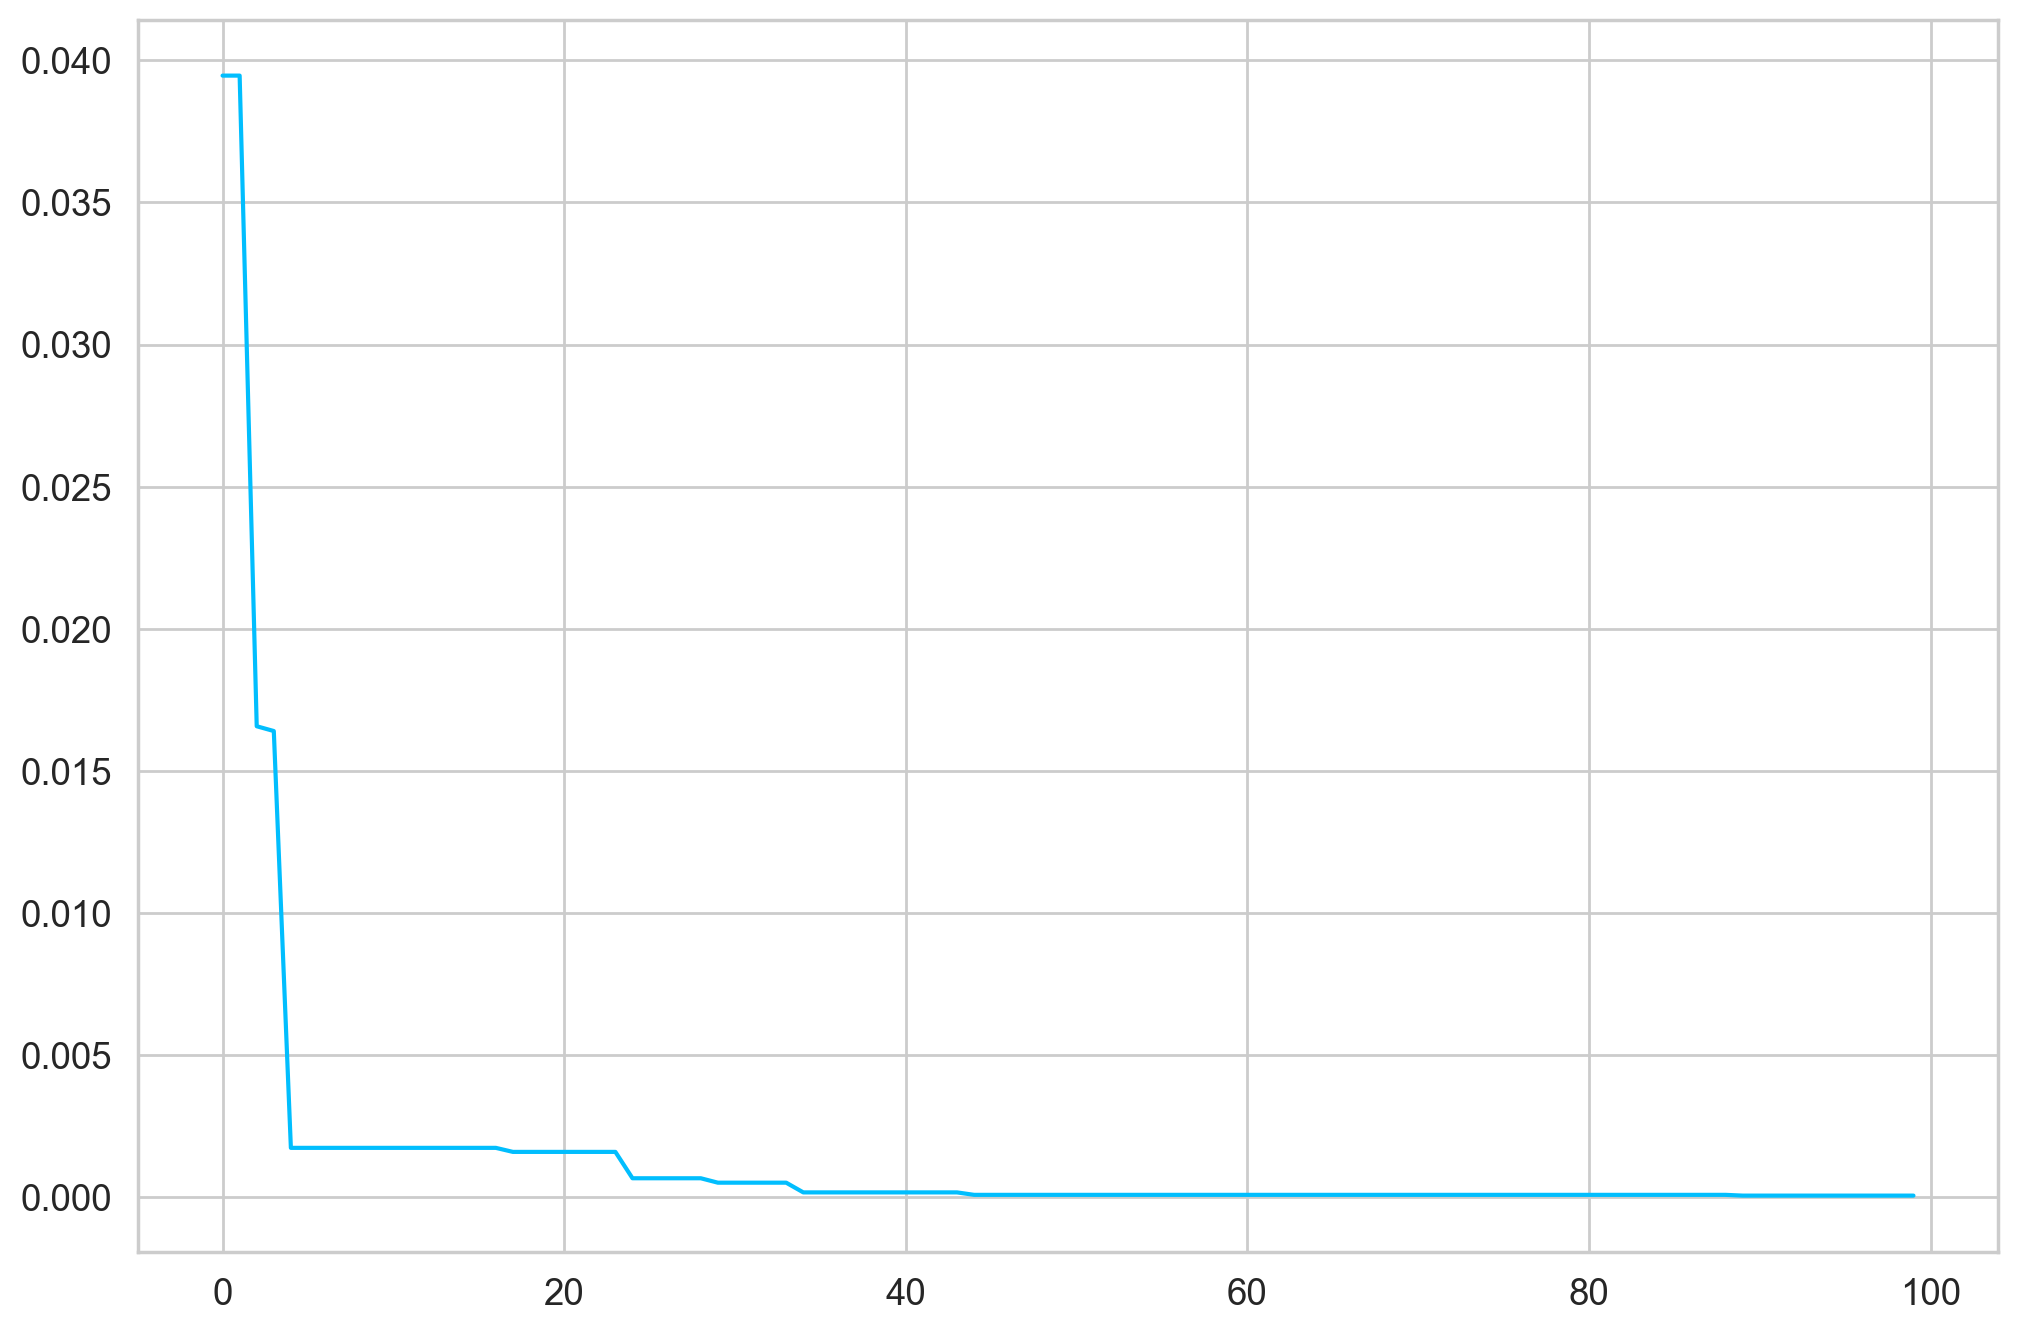

In [22]:
plt.plot(all_res_eb1[0][2])

In [87]:
file = open('svmd_ebqpso_1', 'ab')
pickle.dump(all_results_eb, file)
file.close()

In [90]:
df = pd.read_csv('inputs/SVMD_2.csv')

In [91]:
df

,IMF-1,IMF-2,IMF-3,IMF-4,IMF-5,IMF-6
0,8.975682,-0.038366,0.624298,-0.111836,-1.479115,0.140007
1,8.975958,-0.039837,0.619370,-0.108724,-1.371954,0.109530
2,8.976509,-0.042764,0.609499,-0.102614,-1.165522,0.055161
3,8.977335,-0.047117,0.594654,-0.093728,-0.875014,-0.011347
4,8.978432,-0.052852,0.574799,-0.082388,-0.521791,-0.075600
...,...,...,...,...,...,...
1483,5.601922,0.361429,-1.515532,-0.451945,0.235773,0.090175
1484,5.599218,0.370347,-1.653226,-0.527500,0.425384,0.033315
1485,5.597188,0.377066,-1.759060,-0.586277,0.582773,-0.030621
1486,5.595834,0.381560,-1.830853,-0.626484,0.695309,-0.085161


In [92]:
imfs_2 = np.array([df[col] for col in df.columns])

In [93]:
imfs_2.shape

(6, 1488)

In [94]:
all_results_eb_2 = {}

In [95]:
for i in range(len(imfs_2)):
    X = imfs_2[i, :]
    params, best_err, hist = EBQPSO(f, D, nPop, lb, ub, maxit, lambda_)
    all_results_eb_2[i] = [adjust_params(params), best_err, hist]
    

In [ ]:
file = open('svmd_ebqpso_2', 'ab')
pickle.dump(all_results_eb_2, file)
file.close()

In [84]:
for i in range(5):
    print(all_results_eb[i][1])

6.416298508687886e-05
0.0002593228758193951
0.0008102064756411002
0.0007092862327713127
0.00034426424149213726


In [78]:
for i in range(5):
    print(all_res_p[i][1])

0.00010753946135394066
0.0003157904490286344
0.000810137744272622
0.0007092861881168852
0.00032927844947290514


In [82]:
for i in range(5):
    print(all_res_q[i][1])

8.715923809241029e-05
0.00031579875712524005
0.0008101396185781249
0.0007092881696410329
0.00035896471402841373


In [22]:
from qpso import QPSO

In [23]:
all_res_q = {}

In [24]:
for i in range(len(imfs)):
    X = imfs[i]
    params, best_err, hist = QPSO(f, D, nPop, lb, ub, maxit)
    all_res_q[i] = [adjust_params(params), best_err, hist]
    

In [27]:
all_res_q[2][:2]

[[1000.0, 2.012134847038963, 4], 0.0008106019534017482]

In [30]:
params, best_err, hist = QPSO(f, D, nPop, lb, ub, maxit)

In [29]:
all_res_p = {}

In [49]:
from pso import pso

In [52]:
for i in range(len(imfs)):
    X = imfs[i]
    params, best_err, hist = pso(f, lb, ub, swarmsize=nPop, maxiter=maxit)
    all_res_p[i] = [adjust_params(params), best_err, hist]
    

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


In [76]:
all_res_p[0][1]

0.00010753946135394066

In [86]:
file = open('vmd_pso', 'ab')
pickle.dump(all_res_p, file)
file.close()

In [25]:
file = open('vmd_qpso', 'ab')
pickle.dump(all_res_q, file)
file.close()

In [ ]:
file = open('svmd_ebqpso_1', 'ab')
pickle.dump(all_results_eb_1, file)
file.close()

In [70]:
all_res_q.keys()

dict_keys([0, 1, 2, 3, 4])

In [51]:
pso(f, lb, ub, swarmsize=nPop, maxiter=maxit)

Stopping search: Swarm best objective change less than 1e-08


(array([3.        , 0.44874739, 6.29992727]),
 0.00010739495332589927,
 [0.00024333987933123993,
  0.00024333987933123993,
  0.00014232316353515986,
  0.00012242954519293105,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511])

In [32]:
best_err

0.00031588543392647783

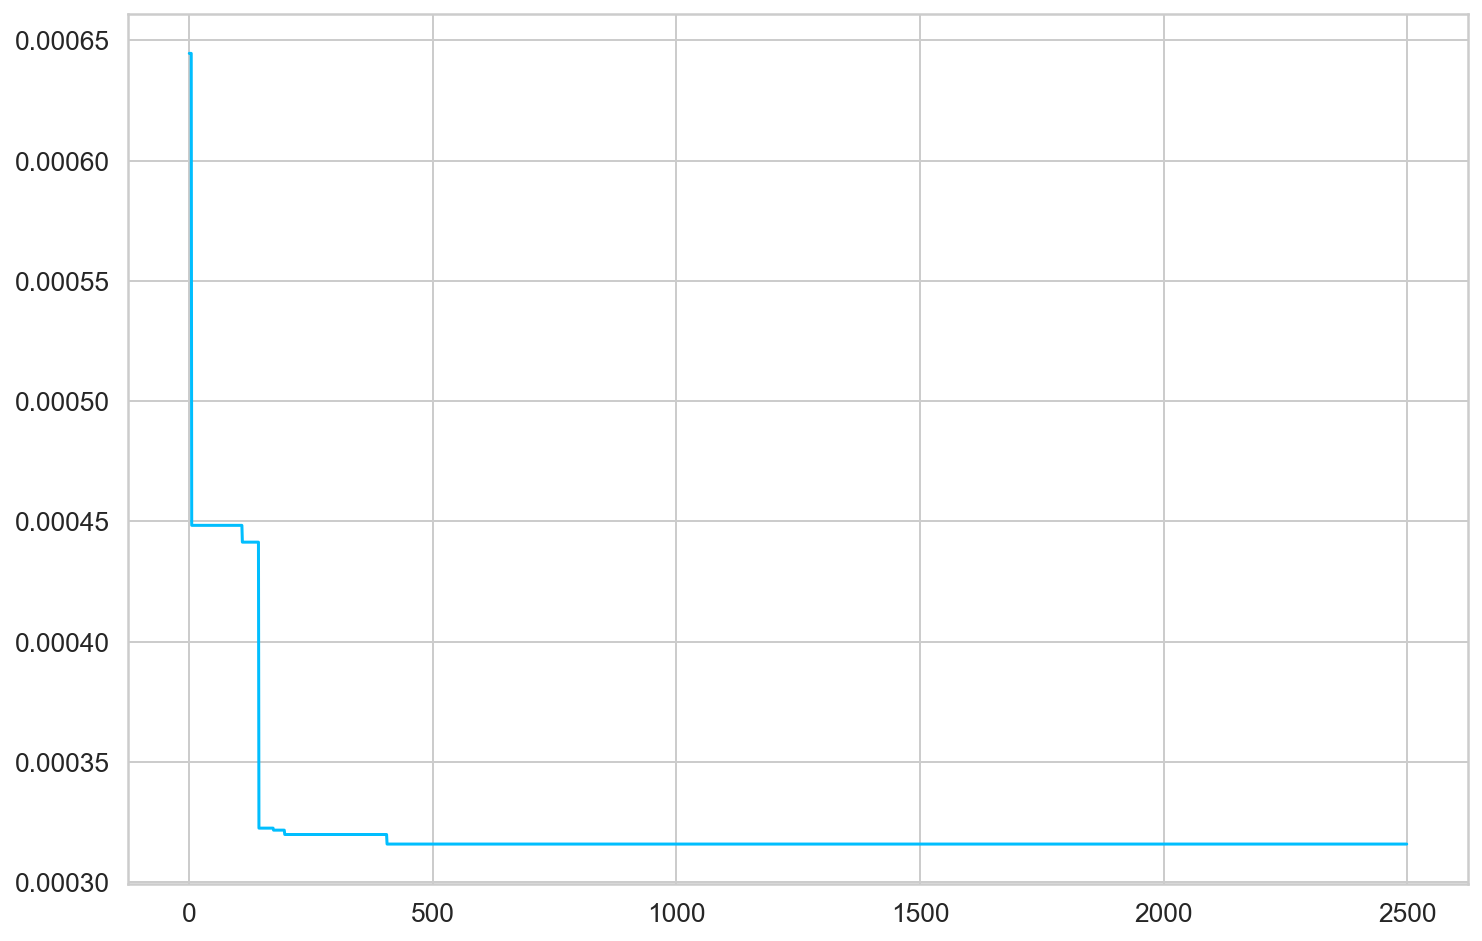

In [33]:
plt.plot(hist)

In [34]:
from pyswarm import pso

In [37]:
xopt, fopt = pso(f, lb, ub, maxiter=maxit)

Stopping search: Swarm best objective change less than 1e-08


In [38]:
xopt

array([3.        , 0.39223398, 3.64247139])

In [39]:
fopt

0.00031579063605412634

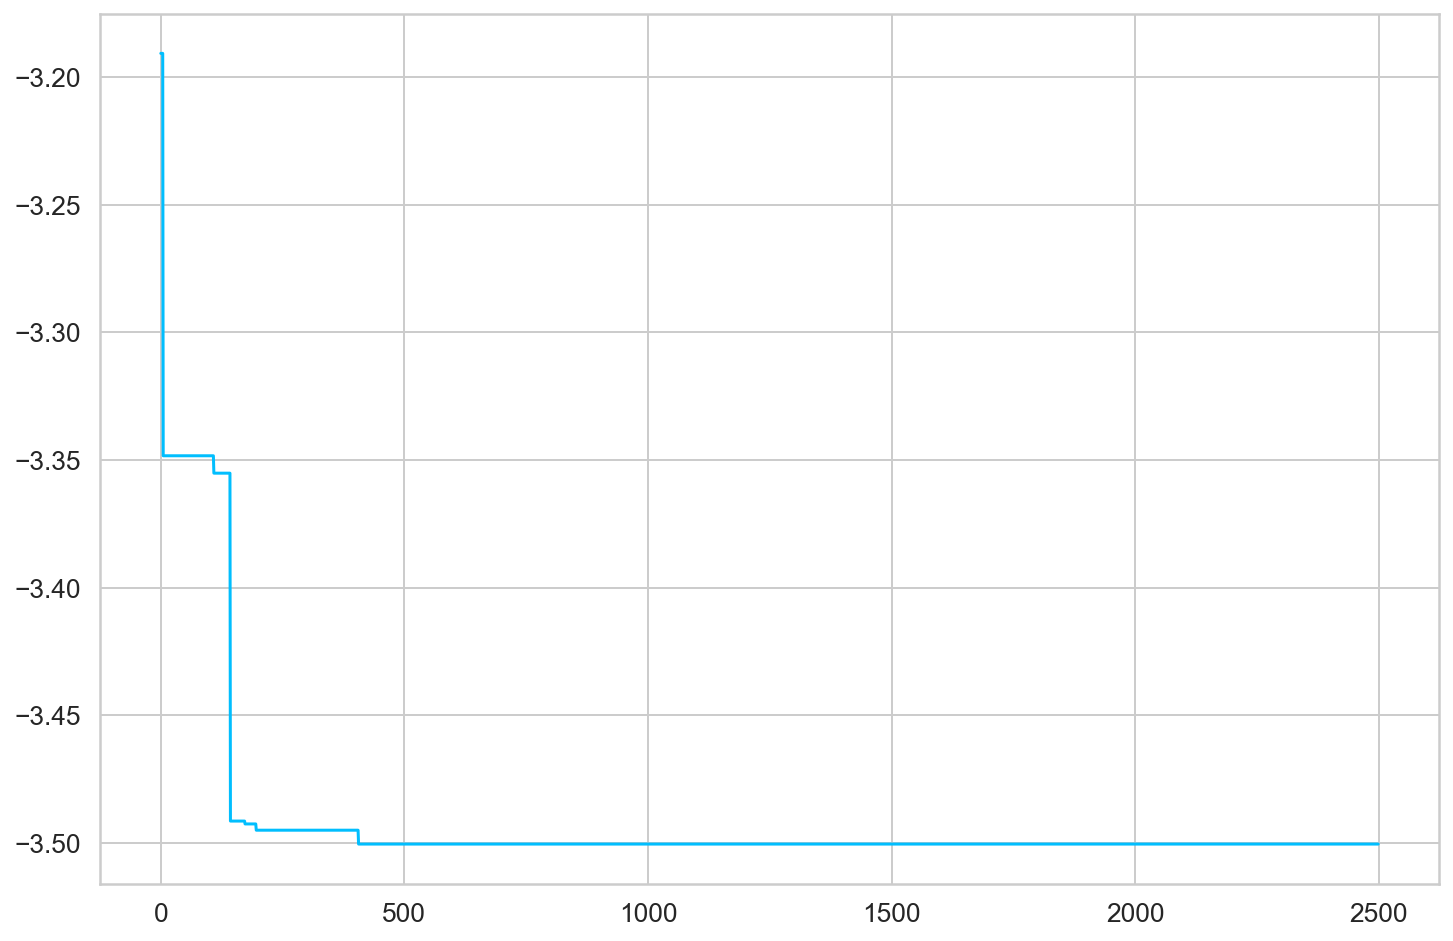

In [41]:
plt.plot(np.log10(hist))